In [20]:
import matplotlib.pyplot as plt
from utils import create_dataset,model_plot,history_plot,prepare_dataset
import glob 
import numpy as np
import os
import random
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2 
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_absolute_error as mae
import seaborn as sns
from tensorflow.keras.models import load_model

In [2]:
df = pd.read_csv('../datasets/yt_subscribers.csv')
print(df.head(10))

         Date  Subscribers  Unnamed: 2  Unnamed: 3  Unnamed: 4
0   8/26/2024           40         NaN         NaN         NaN
1  10/13/2024           39         NaN         NaN         NaN
2   3/28/2024           38         NaN         NaN         NaN
3   8/25/2024           38         NaN         NaN         NaN
4   7/18/2024           37         NaN         NaN         NaN
5   9/16/2024           36         NaN         NaN         NaN
6   8/10/2024           34         NaN         NaN         NaN
7   7/26/2024           33         NaN         NaN         NaN
8    9/1/2024           33         NaN         NaN         NaN
9   11/4/2024           33         NaN         NaN         NaN


In [3]:
df['Date'] = pd.to_datetime(df['Date'])

In [4]:
clean_df = df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])
clean_df.sort_values(by='Date', inplace=True)
print(clean_df.head(10))

          Date  Subscribers
254 2023-11-15           13
336 2023-11-16            8
349 2023-11-17            6
301 2023-11-18           10
215 2023-11-19           15
180 2023-11-20           17
361 2023-11-21            3
337 2023-11-22            8
355 2023-11-23            5
338 2023-11-24            8


In [5]:
# Extract day of the week (0=Monday, 6=Sunday)
clean_df['day_of_week'] = clean_df['Date'].dt.dayofweek
clean_df.set_index('Date', inplace=True)
print(clean_df)

            Subscribers  day_of_week
Date                                
2023-11-15           13            2
2023-11-16            8            3
2023-11-17            6            4
2023-11-18           10            5
2023-11-19           15            6
...                 ...          ...
2024-11-09           25            5
2024-11-10           27            6
2024-11-11           20            0
2024-11-12           18            1
2024-11-13           25            2

[365 rows x 2 columns]


<Axes: xlabel='day_of_week', ylabel='count'>

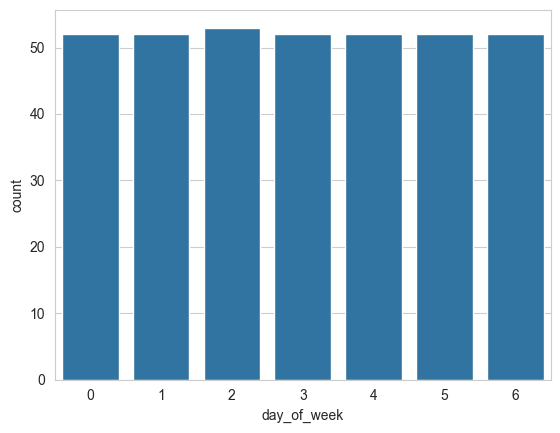

In [6]:
sns.set_style('whitegrid')
sns.countplot(x='day_of_week',data=clean_df)

<Axes: xlabel='Subscribers', ylabel='count'>

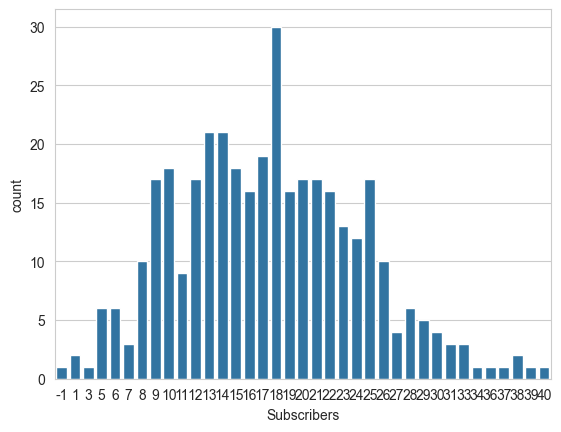

In [7]:
sns.set_style('whitegrid')
sns.countplot(x='Subscribers',data=clean_df)

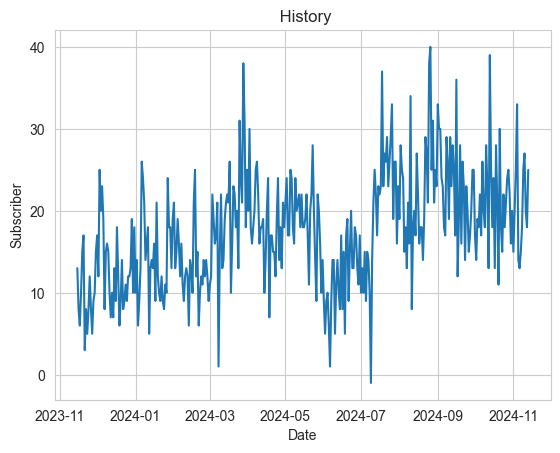

In [8]:
plt.title(' History')
plt.plot(clean_df["Subscribers"])
plt.xlabel('Date')
plt.ylabel('Subscriber')
plt.show()

In [9]:
df = np.array(clean_df.iloc[:])
df[:5]

array([[13,  2],
       [ 8,  3],
       [ 6,  4],
       [10,  5],
       [15,  6]], dtype=int64)

In [10]:
ratio = 0.80

train_size = int(len(df) * ratio)  
test_size = len(df) - train_size 

In [11]:
train_data = df[:train_size]  
test_data = df[train_size:]   

print(f"All data: {len(df)} ")
print(f"Train data: {len(train_data)} ")
print(f"Test data: {len(test_data)} ")

All data: 365 
Train data: 292 
Test data: 73 


In [12]:
scaler = MinMaxScaler(feature_range=(0,1))
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

In [13]:
def create_dataset(dataset, time_step=1, output=1):
    X, Y = [], []

    for i in range(len(dataset) - time_step - output):
        a = dataset[i:(i + time_step), 0]
        X.append(a)
        
        b = dataset[(i + time_step):(i + time_step + output), 0]  
        Y.append(b)
    
    return np.array(X), np.array(Y)
time_step=30
output=30
X_train,y_train=create_dataset(train_data,time_step,output)
X_test,y_test=create_dataset(test_data,time_step,output)
print(f"X_train: {X_train.shape} \ny_train: {y_train.shape}\nX_test: {X_test.shape}\ny_test: {y_test.shape}")

X_train: (232, 30) 
y_train: (232, 30)
X_test: (13, 30)
y_test: (13, 30)


In [33]:
lstm_model_1=Sequential()
lstm_model_1.add(LSTM(50,return_sequences=True,input_shape=(30,1)))
lstm_model_1.add(LSTM(50,return_sequences=True))
lstm_model_1.add(LSTM(50))
lstm_model_1.add(Dense(30))
lstm_model_1.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.03), metrics=['mean_absolute_error'])
lstm_model_1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 30, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 30, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │         1,530 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,330 (204.41 KB)

 Trainable params: 52,330 (204.41 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
history_3=lstm_model_1.fit(
    X_train,y_train,
    epochs=100,
    validation_data=(X_test,y_test),
    verbose=1,
)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.4329 - mean_absolute_error: 0.4329 - val_loss: 0.2758 - val_mean_absolute_error: 0.2758
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1971 - mean_absolute_error: 0.1971 - val_loss: 0.1406 - val_mean_absolute_error: 0.1406
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1335 - mean_absolute_error: 0.1335 - val_loss: 0.1420 - val_mean_absolute_error: 0.1420
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1304 - mean_absolute_error: 0.1304 - val_loss: 0.1557 - val_mean_absolute_error: 0.1557
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1290 - mean_absolute_error: 0.1290 - val_loss: 0.1512 - val_mean_absolute_error: 0.1512
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1278 - mean_absolute_error: 0.1278 - val_loss: 0.1325 - val_mean_absolute_error: 0.1325
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1297 - mean_absolute_error: 0.1297 - val_loss: 0.152

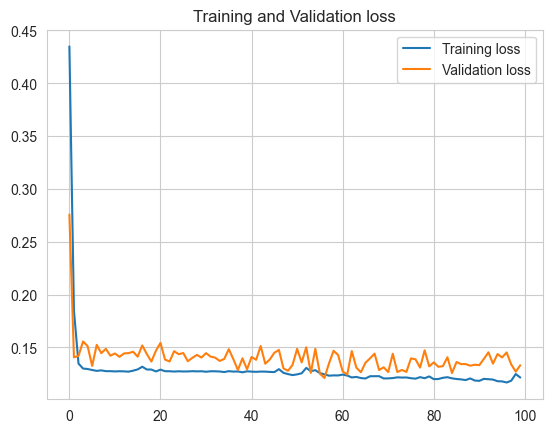

In [35]:
history_plot(history_3)

In [36]:
train_predicted=lstm_model_1.predict(X_train)
test_predicted=lstm_model_1.predict(X_test)

1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/stepWARNING:tensorflow:5 out of the last 17 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000020745F09160> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [37]:
mae_error_train= mae(y_train,train_predicted)
mae_error_test= mae(y_test,test_predicted)
print(f"MAE Train data  : {mae_error_train} ")
print(f"MAE  Test data : {mae_error_test} ")

MAE Train data  : 0.11993925555556692 
MAE  Test data : 0.13312275636896934 


In [38]:
x_train_first_5 = X_train[0]

def subscribe_forcasting(model, X_train, n_step=1,number_to_shift=-1):
    y_prediction_day = []
    input_window = X_train[0].copy()  

    for i in range(1, n_step + 1):
        print(f"\nStep {i} ==>  Input Window: {input_window}")
        
        try:
            y_temp = model.predict(input_window.reshape(1, -1))  
            print(f"Prediction Output (y_temp): {y_temp} ")
            y_prediction_day.append(y_temp[0][0]) 
            input_window = np.roll(input_window, number_to_shift)  # Roll/shift the window to the left
            input_window[-1] = y_temp[0][0]  # Replace the last element with the new prediction    
        except Exception as e:
            print(f"Error during prediction at Step {i}: {e}")
            break  # Stop the loop if an error occurs
    
    return np.array(y_prediction_day)

predictions = subscribe_forcasting(lstm_model_1, X_train, n_step=30,number_to_shift=-10)
print("\nPredicted values for the next steps:", predictions)



Step 1 ==>  Input Window: [0.34146341 0.2195122  0.17073171 0.26829268 0.3902439  0.43902439
 0.09756098 0.2195122  0.14634146 0.2195122  0.31707317 0.2195122
 0.14634146 0.24390244 0.26829268 0.3902439  0.43902439 0.31707317
 0.63414634 0.51219512 0.58536585 0.48780488 0.2195122  0.3902439
 0.41463415 0.3902439  0.26829268 0.19512195 0.26829268 0.19512195]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction Output (y_temp): [[0.30155763 0.3088931  0.31158638 0.34146336 0.34651425 0.377268
  0.3651424  0.36536163 0.38168964 0.37782001 0.40824574 0.41001365
  0.4057656  0.40744814 0.37879458 0.39653102 0.40050036 0.38627863
  0.4355817  0.4528118  0.43627882 0.46648613 0.44104517 0.43209293
  0.45103654 0.45885587 0.43006584 0.42521927 0.434985   0.4481074 ]] 

Step 2 ==>  Input Window: [0.31707317 0.2195122  0.14634146 0.24390244 0.26829268 0.3902439
 0.43902439 0.31707317 0.63414634 0.51219512 0.58536585 0.48780488
 0.2195122  0.3902439  0.41463415 0.3902439  0.26829268 0.19512195
 0.26

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


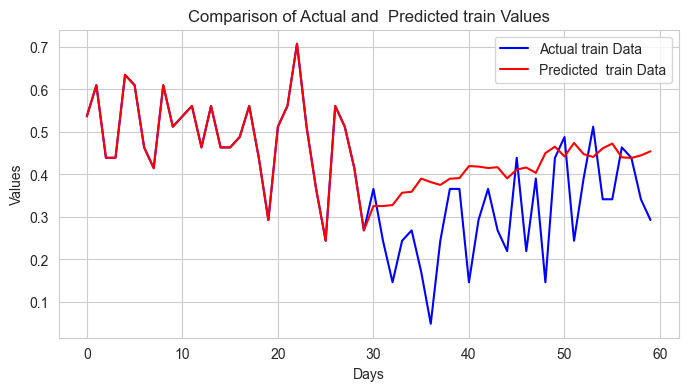

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


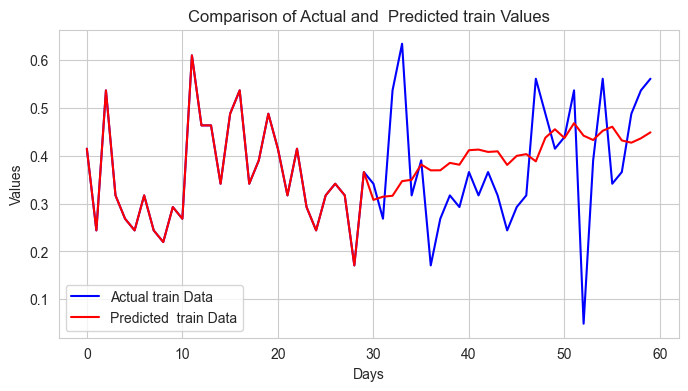

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


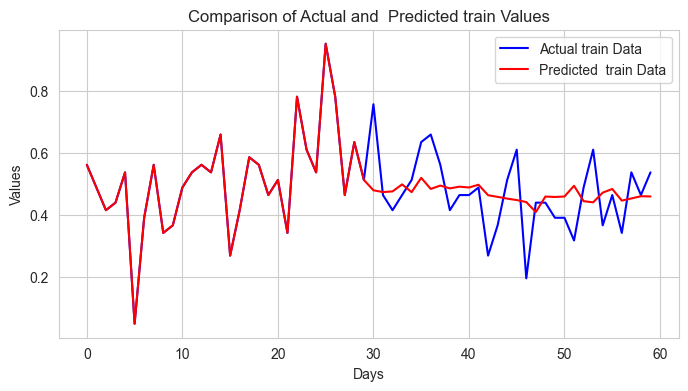

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


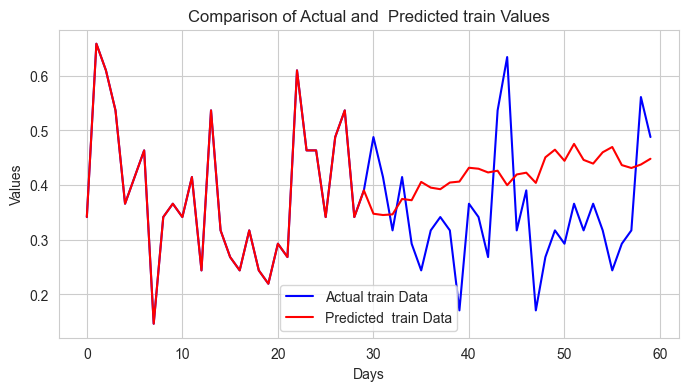

In [39]:
def calculate_random_sequences(n_random, model, X_train):
    for i in range(n_random):
        r = random.randint(0, len(X_train)-30)
        x_temp = X_train[r]
        original_data = list(x_temp)
        for idx in range(1, 31):
            y_next = X_train[r+idx]
            original_data.append(y_next[-1])
        y_temp = model.predict(x_temp.reshape(1, -1))
        x_input = np.array(x_temp)
        y_output = np.array(y_temp).reshape(-1)
        predicted_result = np.concatenate((x_input, y_output))


        plt.figure(figsize=(8, 4))
        plt.plot(original_data, label='Actual train Data', color='blue')
        plt.plot(predicted_result, label='Predicted  train Data', color='red')
        plt.title('Comparison of Actual and  Predicted train Values')
        plt.xlabel('Days')
        plt.ylabel('Values')
        plt.legend()
        plt.show()
calculate_random_sequences(4,lstm_model_1,X_train)

## N_steps =30 number_to_shift = -30

In [42]:
predictions = subscribe_forcasting(lstm_model_1, X_train, n_step=30,number_to_shift=-30)
print("\nPredicted values for the next steps:", predictions)


Step 1 ==>  Input Window: [0.34146341 0.2195122  0.17073171 0.26829268 0.3902439  0.43902439
 0.09756098 0.2195122  0.14634146 0.2195122  0.31707317 0.2195122
 0.14634146 0.24390244 0.26829268 0.3902439  0.43902439 0.31707317
 0.63414634 0.51219512 0.58536585 0.48780488 0.2195122  0.3902439
 0.41463415 0.3902439  0.26829268 0.19512195 0.26829268 0.19512195]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Prediction Output (y_temp): [[0.30155763 0.3088931  0.31158638 0.34146336 0.34651425 0.377268
  0.3651424  0.36536163 0.38168964 0.37782001 0.40824574 0.41001365
  0.4057656  0.40744814 0.37879458 0.39653102 0.40050036 0.38627863
  0.4355817  0.4528118  0.43627882 0.46648613 0.44104517 0.43209293
  0.45103654 0.45885587 0.43006584 0.42521927 0.434985   0.4481074 ]] 

Step 2 ==>  Input Window: [0.34146341 0.2195122  0.17073171 0.26829268 0.3902439  0.43902439
 0.09756098 0.2195122  0.14634146 0.2195122  0.31707317 0.2195122
 0.14634146 0.24390244 0.26829268 0.3902439  0.43902439 0.31707317
 0.63

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


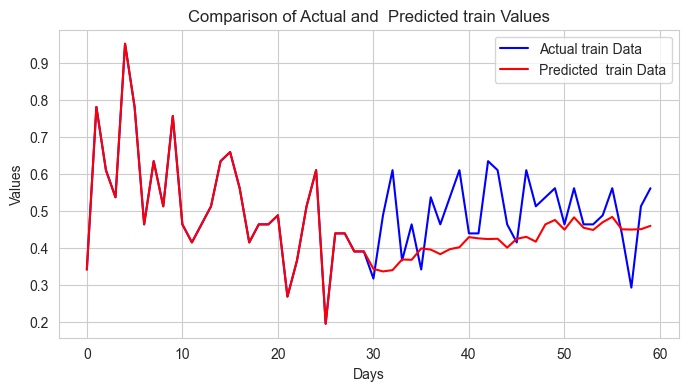

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


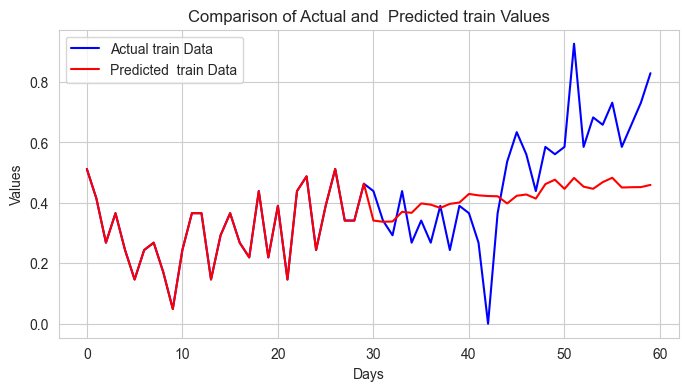

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


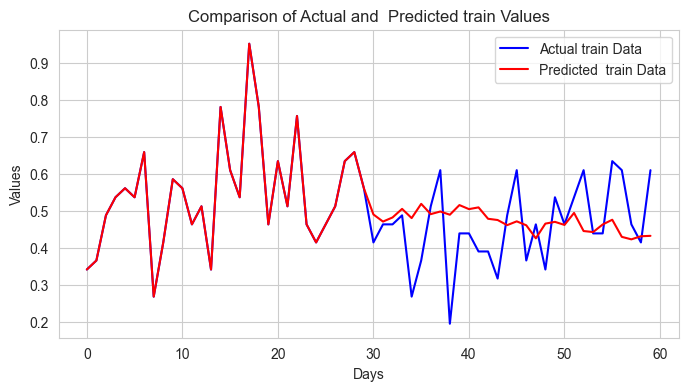

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


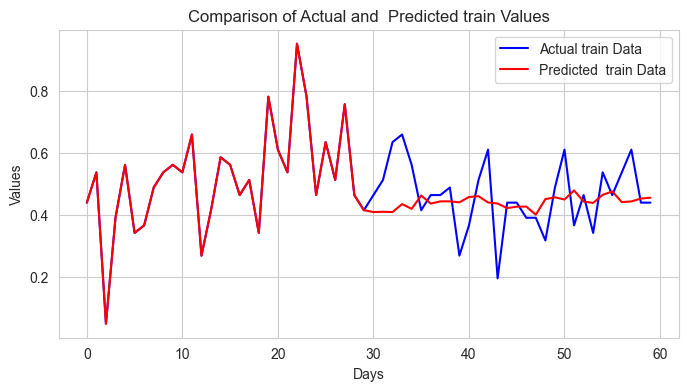

In [43]:
calculate_random_sequences(4,lstm_model_1, X_train)